In [2]:
import os

# move up from notebooks -> project root
os.chdir(os.path.join(os.getcwd(),os.pardir))
print("Working dir is now:", os.getcwd())


import torch 
import numpy as np
import matplotlib.pyplot as plt

from initialize import OUTPUT_PATH, PREPROCESSED_AURORA_DATA_PATH


Working dir is now: /Users/adrian/Documents/01_projects/02_clean_ppg


In [3]:
data_path = os.path.join(PREPROCESSED_AURORA_DATA_PATH, "data_dict_osc_auc_with_derivatives_with_classes.pt")
# Load the data
data = torch.load(data_path, weights_only=False)

# Ensemble PWs of each subject and their derivatives


/var/folders/b2/80yhhgwn2fjb5qv0cbj_cr6c0000gn/T/ipykernel_4764/2361854939.py:92: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Saved figure for subject a000.


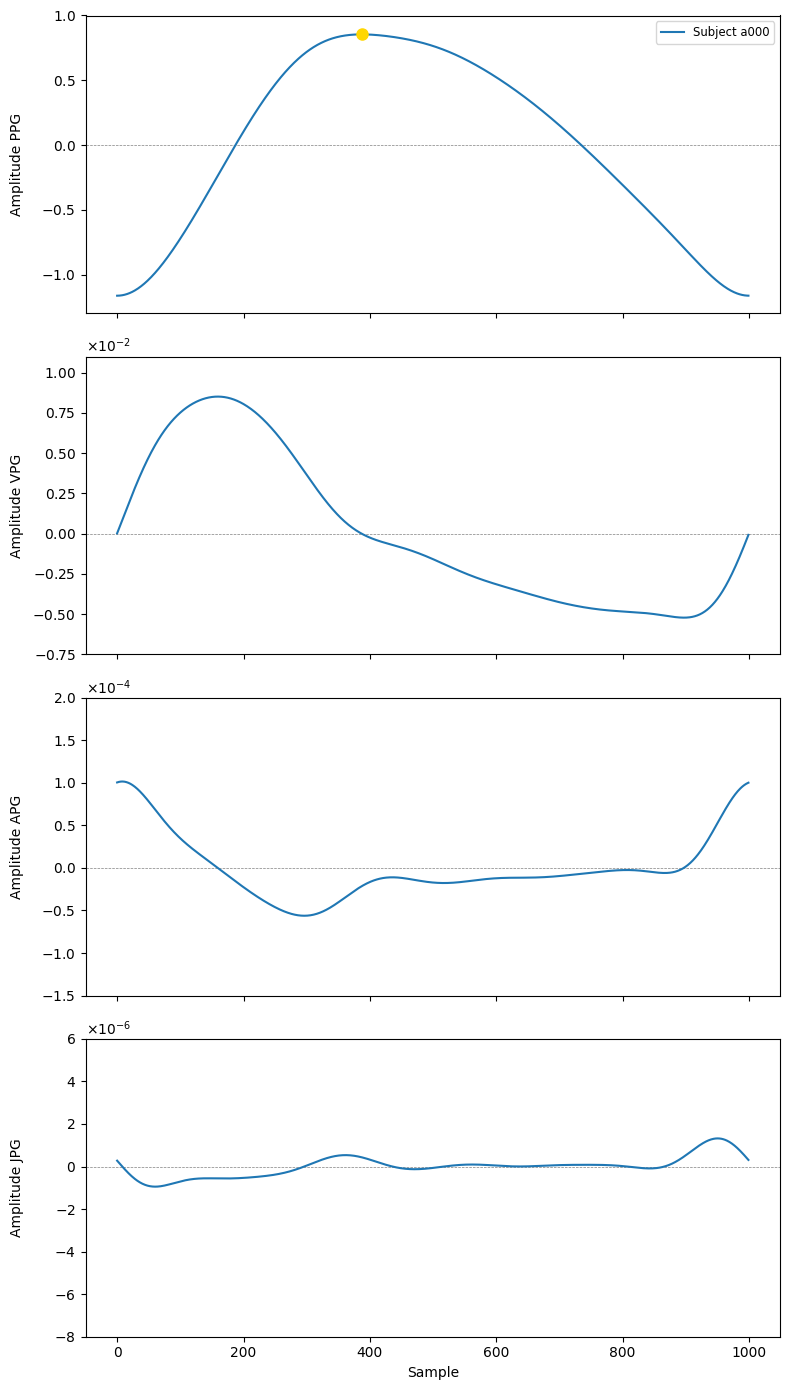

In [ ]:
PLOT_ENSEMBLE_PWS_OF_EACH_SUBJECT = True

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

if PLOT_ENSEMBLE_PWS_OF_EACH_SUBJECT:
    from scipy.signal import argrelextrema

    os.makedirs(os.path.join(OUTPUT_PATH, "waves_and_derivatives_for_each_subject"), exist_ok=True)

    wave_types       = ["ensemble_ppg_avg", "ensemble_vpg_avg", "ensemble_apg_avg", "ensemble_jpg_avg"]
    names_wave_types = ["PPG",   "VPG",   "APG",   "JPG"]
    # y axis limits for each wave type
    y_limits = {
        "ensemble_ppg_avg": (-1.3, 1), # -0.7e0, 0.7e0),
        "ensemble_vpg_avg": (-0.75e-2, 1.1e-2),
        "ensemble_apg_avg": (-1.5e-4, 2.0e-4),
        "ensemble_jpg_avg": (-8e-6, 6e-6)
    }

    for subj_id, subject_data in data.items():
        # Turn on constrained_layout so space for labels/offsets is reserved automatically
        fig, axes = plt.subplots(4, 1,
                                figsize=(4, 10),
                                sharex=True,
                                constrained_layout=True)
        

        # subj_id = "a084"

        # fig.suptitle(f"Subject {subj_id}", fontsize=14)

        for ax, wave_type, name in zip(axes, wave_types, names_wave_types):

            # plot a horizontal line at y=0
            ax.axhline(0, color='gray', lw=0.5, ls='--')

            # plot the wave type data
            ax.plot(subject_data[wave_type], label="Subject " + subj_id)

            # --- Scientific formatting with a shared offset ---
            ax.ticklabel_format(style='scientific',
                                axis='y',
                                scilimits=(-1, 1),
                                useMathText=True)

            # Force the offset-text to the *left* of the axis
            ax.yaxis.offsetText.set_x(-0.1)        # tweak horizontal position
            ax.yaxis.offsetText.set_ha('right')    # right-align so it hugs the ticklabels
            ax.yaxis.set_offset_position('left')   # tell Matplotlib it belongs on the left
            ax.set_ylim(y_limits[wave_type])

            # Label on the left, same pad for all
            ax.set_ylabel(f"Amplitude {name}", labelpad=6)

            # Add a yellow big point to the peak of the PPG wave. Add small blue dots for all local maxima and minima of the PPG wave.
            if wave_type == "ensemble_ppg_avg":
                
                # Add small blue dots for all local maxima and minima of the PPG wave.
                local_max_indices = argrelextrema(subject_data[wave_type], np.greater)[0]
                local_min_indices = argrelextrema(subject_data[wave_type], np.less)[0]
                local_min_indices = local_min_indices[local_min_indices < 950]  # only consider minima that are not at the end. Cosmetics.
                local_min_indices = local_min_indices[local_min_indices > 50]  # only consider minima that are ot at the start. Cosmetics.
                ax.plot(local_max_indices, subject_data[wave_type][local_max_indices], 'bo', markersize=5) #, label='Local Maxima')
                ax.plot(local_min_indices, subject_data[wave_type][local_min_indices], 'ko', markersize=5) # , label='Local Minima')

                # Add the big yellow point
                peak_index = np.argmax(subject_data[wave_type])
                peak_value = subject_data[wave_type][peak_index]
                ax.plot(peak_index, peak_value, color='gold', marker='o', markersize=8) # , label='Peak PPG')

            # Color for the APG wave the area between the wave and the x-axis yellow (but only between x=300 and x=600).
            if wave_type == "ensemble_apg_avg":
                x_fill_start = 200
                x_fill_end = 800
                # Mask the data that only if the value of the wave is at that point >0
                # to avoid filling the area below the x-axis
                y_fill = subject_data[wave_type][x_fill_start:x_fill_end].copy()
                y_fill[y_fill < 0] = 0  # Ensure y_fill is non-negative
                ax.fill_between(range(x_fill_start, x_fill_end), y_fill, color='gold', edgecolor='none', alpha=1, label='APG Area')

        axes[0].legend(loc='upper right', fontsize='small')
        axes[-1].set_xlabel("Sample")

        # Only bottom subplot gets x-tick labels
        for ax in axes[:-1]:
            ax.tick_params(labelbottom=False)   # or ax.label_outer()
        axes[-1].set_xticks(range(0, 1001, 200))

        # This will align all y-labels in one vertical column
        fig.align_ylabels(axes)
        plt.tight_layout()
        os.makedirs(os.path.join(OUTPUT_PATH, "waves_and_derivatives_for_each_subject_no_title"), exist_ok=True)
        plt.savefig(os.path.join(OUTPUT_PATH, "waves_and_derivatives_for_each_subject_no_title", f"subject_{subj_id}_pulse_wave_and_derivatives.png"))
        # plt.show()
        print(f"Saved figure for subject {subj_id}.")
        # break



/var/folders/b2/80yhhgwn2fjb5qv0cbj_cr6c0000gn/T/ipykernel_4764/1019522826.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Saved figure.
/Users/adrian/Documents/01_projects/02_clean_ppg/output/five_wave_classes_overview


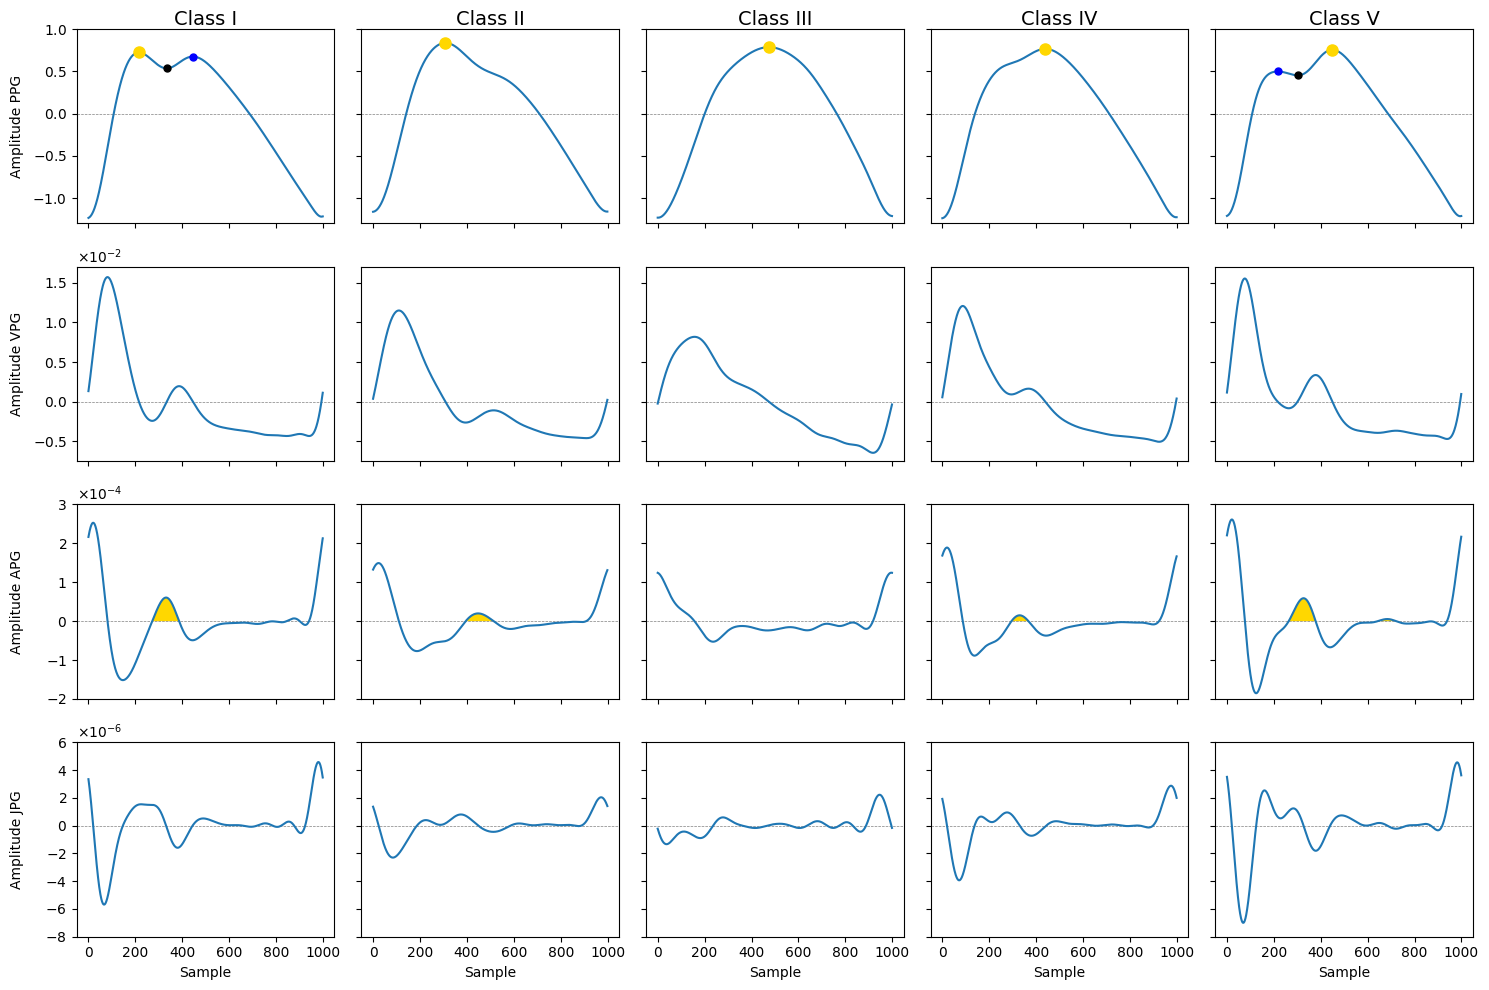

In [36]:
from scipy.signal import argrelextrema

folder_path = os.path.join(OUTPUT_PATH, "five_wave_classes_overview")

os.makedirs(folder_path, exist_ok=True)

wave_types       = ["ensemble_ppg_avg", "ensemble_vpg_avg", "ensemble_apg_avg", "ensemble_jpg_avg"]
names_wave_types = ["PPG",   "VPG",   "APG",   "JPG"]

subject_ids = ["a480", "a156", "a027", "a560", "a084"]
class_names = ["Class I", "Class II", "Class III", "Class IV", "Class V"]

# y axis limits for each wave type
y_limits = {
    "ensemble_ppg_avg": (-1.3, 1), # -0.7e0, 0.7e0),
    "ensemble_vpg_avg": (-0.75e-2, 1.7e-2),
    "ensemble_apg_avg": (-2e-4, 3.0e-4),
    "ensemble_jpg_avg": (-8e-6, 6e-6)
}

fig, axes = plt.subplots(4, 5,
                        figsize=(15, 10),
                        sharex=True,
                        constrained_layout=True)

for i, subj_id in enumerate(subject_ids): 
    subject_data = data[subj_id]

    the_four_axes = axes[:, i]    

    # fig.suptitle(f"Subject {subj_id}", fontsize=14)

    for ax, wave_type, name in zip(the_four_axes, wave_types, names_wave_types):

        # plot a horizontal line at y=0
        ax.axhline(0, color='gray', lw=0.5, ls='--')

        # plot the wave type data
        ax.plot(subject_data[wave_type], label="Subject " + subj_id)
        
        # --- Scientific formatting with a shared offset ---
        ax.ticklabel_format(style='scientific',
                            axis='y',
                            scilimits=(-1, 1),
                            useMathText=True)
    
        ax.set_ylim(y_limits[wave_type])

        # Force the offset-text to the *left* of the axis
        if i == 0:  # Only for the first column
            ax.yaxis.offsetText.set_x(-0.1)        # tweak horizontal position
            ax.yaxis.offsetText.set_ha('right')    # right-align so it hugs the ticklabels
            ax.yaxis.set_offset_position('left')   # tell Matplotlib it belongs on the left
            
            # Label on the left, same pad for all
            ax.set_ylabel(f"Amplitude {name}", labelpad=6)

        else: 
            ax.set_yticklabels([])  # Remove y-tick labels for other columns

        # Add a yellow big point to the peak of the PPG wave. Add small blue dots for all local maxima and minima of the PPG wave.
        if wave_type == "ensemble_ppg_avg":
            
            ax.set_title(class_names[i], fontsize=14, pad=2)

            # Add small blue dots for all local maxima and minima of the PPG wave.
            local_max_indices = argrelextrema(subject_data[wave_type], np.greater)[0]
            local_min_indices = argrelextrema(subject_data[wave_type], np.less)[0]
            local_min_indices = local_min_indices[local_min_indices < 950]  # only consider minima that are not at the end. Cosmetics.
            local_min_indices = local_min_indices[local_min_indices > 50]  # only consider minima that are ot at the start. Cosmetics.
            ax.plot(local_max_indices, subject_data[wave_type][local_max_indices], 'bo', markersize=5) #, label='Local Maxima')
            ax.plot(local_min_indices, subject_data[wave_type][local_min_indices], 'ko', markersize=5) # , label='Local Minima')

            # Add the big yellow point
            peak_index = np.argmax(subject_data[wave_type])
            peak_value = subject_data[wave_type][peak_index]
            ax.plot(peak_index, peak_value, color='gold', marker='o', markersize=8) # , label='Peak PPG')

        # Color for the APG wave the area between the wave and the x-axis yellow (but only between x=300 and x=600).
        if wave_type == "ensemble_apg_avg":
            x_fill_start = 200
            x_fill_end = 800
            # Mask the data that only if the value of the wave is at that point >0
            # to avoid filling the area below the x-axis
            y_fill = subject_data[wave_type][x_fill_start:x_fill_end].copy()
            y_fill[y_fill < 0] = 0  # Ensure y_fill is non-negative
            ax.fill_between(range(x_fill_start, x_fill_end), y_fill, color='gold', edgecolor='none', alpha=1, label='APG Area')

    # axes.legend(loc='upper right', fontsize='small')
    # axes[-1].set_xlabel("Sample")
    for ax in axes[-1,:]:
        # ax.legend(loc='upper right', fontsize='small')
        ax.set_xlabel("Sample") 

    # This will align all y-labels in one vertical column
    fig.align_ylabels(axes)
    plt.tight_layout()

plt.savefig(os.path.join(folder_path, f"all_five_classes.svg"))
# plt.show()
print(f"Saved figure.")
print(folder_path)


/var/folders/b2/80yhhgwn2fjb5qv0cbj_cr6c0000gn/T/ipykernel_4764/3837049759.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left') # , fontsize='small')
/var/folders/b2/80yhhgwn2fjb5qv0cbj_cr6c0000gn/T/ipykernel_4764/3837049759.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/b2/80yhhgwn2fjb5qv0cbj_cr6c0000gn/T/ipykernel_4764/3837049759.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left') # , fontsize='small')
/var/folders/b2/80yhhgwn2fjb5qv0cbj_cr6c0000gn/T/ipykernel_4764/3837049759.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called wit

Saved figure.
/Users/adrian/Documents/01_projects/02_clean_ppg/output/five_wave_classes_overview


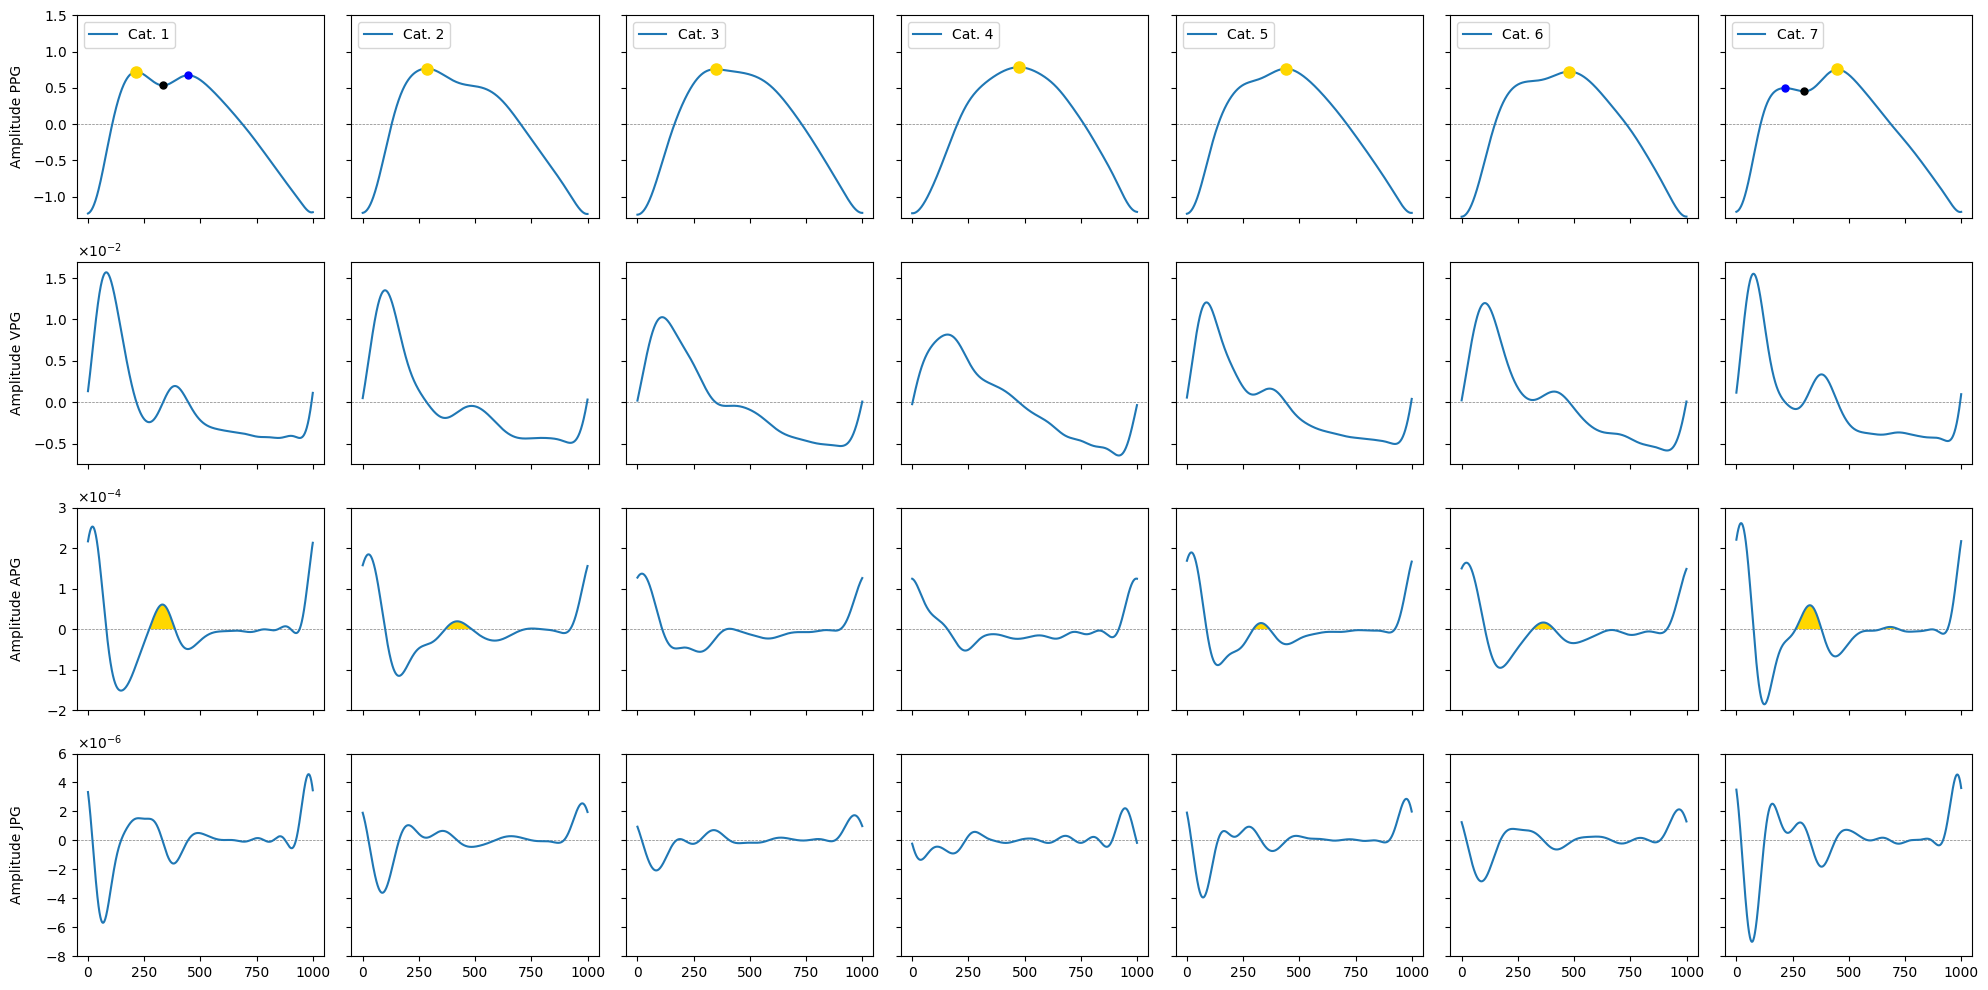

In [37]:
from scipy.signal import argrelextrema

folder_path = os.path.join(OUTPUT_PATH, "five_wave_classes_overview")

os.makedirs(folder_path, exist_ok=True)

wave_types       = ["ensemble_ppg_avg", "ensemble_vpg_avg", "ensemble_apg_avg", "ensemble_jpg_avg"]
names_wave_types = ["PPG",   "VPG",   "APG",   "JPG"]

subject_ids = ["a480", "a488", "a450", "a027", "a560", "a460", "a084"]
class_names = ["Cat. 1", "Cat. 2", "Cat. 3", "Cat. 4", "Cat. 5", "Cat. 6", "Cat. 7"]

# y axis limits for each wave type
y_limits = {
    "ensemble_ppg_avg": (-1.3, 1.5), # -0.7e0, 0.7e0),
    "ensemble_vpg_avg": (-0.75e-2, 1.7e-2),
    "ensemble_apg_avg": (-2e-4, 3.0e-4),
    "ensemble_jpg_avg": (-8e-6, 6e-6)
}

fig, axes = plt.subplots(4, 7,
                        figsize=(20, 10),
                        sharex=True,
                        constrained_layout=True)

for i, subj_id in enumerate(subject_ids): 
    subject_data = data[subj_id]

    the_four_axes = axes[:, i]    

    # fig.suptitle(f"Subject {subj_id}", fontsize=14)

    for ax, wave_type, name in zip(the_four_axes, wave_types, names_wave_types):

        # plot a horizontal line at y=0
        ax.axhline(0, color='gray', lw=0.5, ls='--')

        # plot the wave type data
        ax.plot(subject_data[wave_type], label=class_names[i])
        
        # --- Scientific formatting with a shared offset ---
        ax.ticklabel_format(style='scientific',
                            axis='y',
                            scilimits=(-1, 1),
                            useMathText=True)
    
        ax.set_ylim(y_limits[wave_type])

        # Force the offset-text to the *left* of the axis
        if i == 0:  # Only for the first column
            ax.yaxis.offsetText.set_x(-0.1)        # tweak horizontal position
            ax.yaxis.offsetText.set_ha('right')    # right-align so it hugs the ticklabels
            ax.yaxis.set_offset_position('left')   # tell Matplotlib it belongs on the left
            
            # Label on the left, same pad for all
            ax.set_ylabel(f"Amplitude {name}", labelpad=6)

        else: 
            ax.set_yticklabels([])  # Remove y-tick labels for other columns

        # Add a yellow big point to the peak of the PPG wave. Add small blue dots for all local maxima and minima of the PPG wave.
        if wave_type == "ensemble_ppg_avg":
            
            # ax.set_title(class_names[i], fontsize=14, pad=2)

            # Add small blue dots for all local maxima and minima of the PPG wave.
            local_max_indices = argrelextrema(subject_data[wave_type], np.greater)[0]
            local_min_indices = argrelextrema(subject_data[wave_type], np.less)[0]
            local_min_indices = local_min_indices[local_min_indices < 950]  # only consider minima that are not at the end. Cosmetics.
            local_min_indices = local_min_indices[local_min_indices > 50]  # only consider minima that are ot at the start. Cosmetics.
            ax.plot(local_max_indices, subject_data[wave_type][local_max_indices], 'bo', markersize=5) #, label='Local Maxima')
            ax.plot(local_min_indices, subject_data[wave_type][local_min_indices], 'ko', markersize=5) # , label='Local Minima')

            # Add the big yellow point
            peak_index = np.argmax(subject_data[wave_type])
            peak_value = subject_data[wave_type][peak_index]
            ax.plot(peak_index, peak_value, color='gold', marker='o', markersize=8) # , label='Peak PPG')

        # Color for the APG wave the area between the wave and the x-axis yellow (but only between x=300 and x=600).
        if wave_type == "ensemble_apg_avg":
            x_fill_start = 200
            x_fill_end = 800
            # Mask the data that only if the value of the wave is at that point >0
            # to avoid filling the area below the x-axis
            y_fill = subject_data[wave_type][x_fill_start:x_fill_end].copy()
            y_fill[y_fill < 0] = 0  # Ensure y_fill is non-negative
            ax.fill_between(range(x_fill_start, x_fill_end), y_fill, color='gold', edgecolor='none', alpha=1, label='APG Area')

    # axes.legend(loc='upper right', fontsize='small')
    # axes[-1].set_xlabel("Sample")
    for ax in axes[0,:]:
        ax.legend(loc='upper left') # , fontsize='small')
        # ax.set_xlabel("Sample") 

    # This will align all y-labels in one vertical column
    fig.align_ylabels(axes)
    plt.tight_layout()

plt.savefig(os.path.join(folder_path, f"all_seven_categories.svg"))
# plt.show()
print(f"Saved figure.")
print(folder_path)


In [4]:
subject_data.keys()



dict_keys(['age', 'gender', 'high_bp', 'baseline_sbp', 'baseline_dbp', 'height', 'weight', 'cvd_meds', 'fitzpatrick_scale', 'pressure_quality', 'optical_quality', 'raw_optical', 'delta_t', 'sampling_rate', 'ppg', 'vpg', 'apg', 'jpg', 'fiducials_pyPPG', 'individual_waves', 'fid_on_ppg', 'wave_durations', 'average_hr', 'rise_times_norm', 'rise_times_ms', 'average_rise_time_norm', 'average_rise_time_ms', 'ensemble_wave', 'individual_wave_derivs_ppg_arr', 'individual_wave_derivs_vpg_arr', 'individual_wave_derivs_apg_arr', 'individual_wave_derivs_jpg_arr', 'ensemble_ppg_avg', 'ensemble_vpg_avg', 'ensemble_apg_avg', 'ensemble_jpg_avg', 'oscillo_or_auscul', 'bmi', 'height_m', 'weight_kg', 'individual_waves_classes', 'ensemble_class', 'area_under_the_curve_unsign_wave', 'area_under_the_curve_sign_wave', 'area_under_the_curve_unsign', 'area_under_the_curve_sign'])

In [5]:

# subject_data.keys()
# dict_keys(['age', 'gender', 'high_bp', 'baseline_sbp', 'baseline_dbp', 'height', 'weight', 'cvd_meds', 'fitzpatrick_scale', 'pressure_quality', 'optical_quality', 
# 'raw_optical', 'delta_t', 'sampling_rate', 'ppg', 'vpg', 'apg', 'jpg', 'fiducials_pyPPG', 'individual_waves', 'fid_on_ppg', 'wave_durations', 'average_hr', 
# 'rise_times_norm', 'rise_times_ms', 'average_rise_time_norm', 'average_rise_time_ms', 'ensemble_wave', 'ensemble_ppg', 'ensemble_vpg', 'ensemble_apg', 'ensemble_jpg', 
# 'individual_wave_derivs_ppg_arr', 'individual_wave_derivs_vpg_arr', 'individual_wave_derivs_apg_arr', 'individual_wave_derivs_jpg_arr', 'ensemble_ppg_avg', 'ensemble_vpg_avg', 
# 'ensemble_apg_avg', 'ensemble_jpg_avg', 'oscillo_or_auscul', 'bmi', 'height_m', 'weight_kg', 'individual_waves_classes', 'ensemble_class', 'area_under_the_curve_unsign_wave', 
# 'area_under_the_curve_sign_wave', 'area_under_the_curve_unsign', 'area_under_the_curve_sign'])

# AUC and Classes correlation

In [6]:

class_arr = []
auc_arr = []
for subj_id, subject_data in data.items():
    for i in subject_data["individual_waves_classes"]:
        class_arr.append(i)
    # print(class_arr)
    for i in subject_data["area_under_the_curve_sign_wave"]:
        auc_arr.append(i)
    # print(auc_arr)
    # print(f"Processed subject {subj_id}.")
    # break

print(len(class_arr), len(auc_arr))

17873 17873


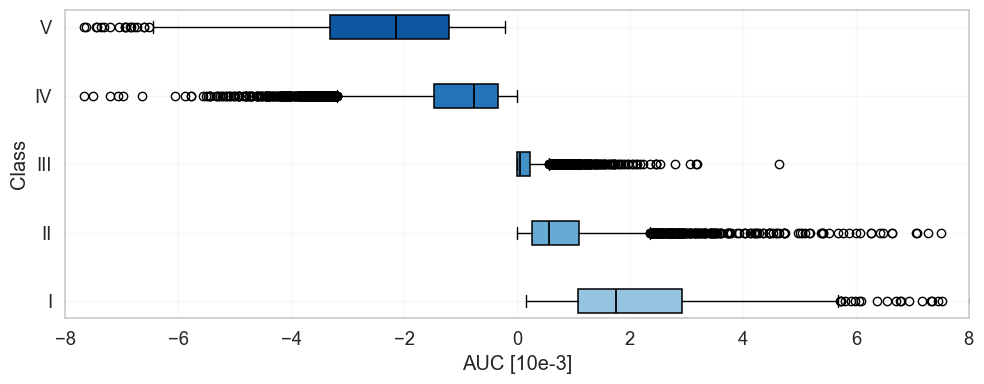

In [40]:
limits = 8
height = 4 # default should be 5

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ---- Data ----
df = pd.DataFrame({'Class': class_arr, 'AUC': auc_arr})
df['AUC_milli'] = df['AUC'] * 1e3  # scale for readability

classes = np.sort(df['Class'].unique())[::-1]  # reverse order for horizontal boxplot
data_by_class = [df.loc[df['Class'] == c, 'AUC_milli'].values for c in classes]

# ---- Figure / style ----
plt.rcParams.update({
    "axes.spines.top": True,
    "axes.spines.right": True,
    "axes.grid": True,
    "grid.alpha": 0.15,
    "font.size": 12
})

fig, ax = plt.subplots(figsize=(10, height))  # flipped aspect ratio

#######
spacing = 2  # try 2.0 if you want more space
positions = np.arange(len(classes)) * spacing + 1  # e.g. [1, 2.5, 4, 5.5, 7]

bp = ax.boxplot(
    data_by_class,
    positions=positions,
    widths=0.7,
    patch_artist=True,
    vert=False
)

ax.set_yticks(positions)
ax.set_yticklabels(["I", "II", "III", "IV", "V"])

#######


# Color the boxes
colors = plt.cm.Blues(np.linspace(0.4, 0.85, len(classes)))
for box, c in zip(bp['boxes'], colors):
    box.set(facecolor=c, edgecolor='black', linewidth=1.1)
for median in bp['medians']:
    median.set(color='black', linewidth=1.3)

ax.set_xlim(-limits, limits)  # set x-limits for better visibility

ax.set_ylabel('Class')
ax.set_xlabel('AUC [10e-3]')
# ax.set_title('Distribution of AUC by Class', pad=15)

plt.tight_layout()
save_path = os.path.join(OUTPUT_PATH, "classes_of_pws")
os.makedirs(save_path, exist_ok=True)
plt.savefig(os.path.join(save_path, f"boxplot_AUC_by_class_height_{height}_lim_{limits}.png"), dpi=300)
plt.savefig(os.path.join(save_path, f"boxplot_AUC_by_class_height_{height}_lim_{limits}.svg"))
plt.show()





In [11]:
subject_data["area_under_the_curve_sign_wave"] # -> The individual AUCs for the individual waves
subject_data["area_under_the_curve_sign"] # -> Average AUC for the subject

2.3479957198319288e-05

# DURATIONS AND CLASS DISTRIBUTIONS


In [12]:
data["a000"].keys()  # to see the available subjects

dict_keys(['age', 'gender', 'high_bp', 'baseline_sbp', 'baseline_dbp', 'height', 'weight', 'cvd_meds', 'fitzpatrick_scale', 'pressure_quality', 'optical_quality', 'raw_optical', 'delta_t', 'sampling_rate', 'ppg', 'vpg', 'apg', 'jpg', 'fiducials_pyPPG', 'individual_waves', 'fid_on_ppg', 'wave_durations', 'average_hr', 'rise_times_norm', 'rise_times_ms', 'average_rise_time_norm', 'average_rise_time_ms', 'ensemble_wave', 'individual_wave_derivs_ppg_arr', 'individual_wave_derivs_vpg_arr', 'individual_wave_derivs_apg_arr', 'individual_wave_derivs_jpg_arr', 'ensemble_ppg_avg', 'ensemble_vpg_avg', 'ensemble_apg_avg', 'ensemble_jpg_avg', 'oscillo_or_auscul', 'bmi', 'height_m', 'weight_kg', 'individual_waves_classes', 'ensemble_class', 'area_under_the_curve_unsign_wave', 'area_under_the_curve_sign_wave', 'area_under_the_curve_unsign', 'area_under_the_curve_sign'])

In [13]:
data["a000"].keys()  # to see the available subjects

available_genders = []
for d in data: 
    available_genders.append(data[d]["gender"])

print("Available genders:", set(available_genders))

Available genders: {'M', 'F'}


In [14]:
len(data)

# number of female subjects
number_of_female_subjects = sum(1 for d in data if data[d]["gender"] == "F")
number_of_female_subjects

340

Distribution of waves per class for ALL
(686, 5)
Distribution of waves per class:
[ 6.4 41.1 23.9 23.5  5.1]


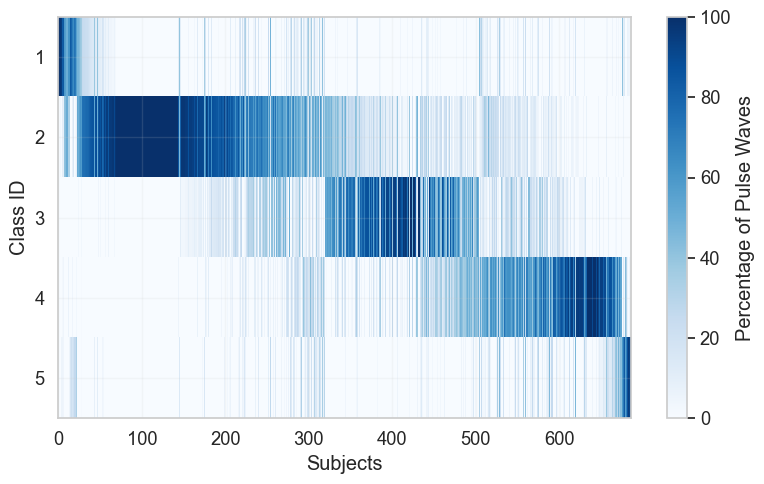

In [42]:
# count how many waves are of class 1,2,3,4,5 for each subject

print("Distribution of waves per class for ALL")
wave_counts = []

for i in data:
    wave_arr = np.zeros(5)
    class_index, w_classes = np.unique(data[i]["individual_waves_classes"], return_counts=True)
    for class_id, w_class in zip(class_index, w_classes):
        wave_arr[class_id-1] = w_class 

    wave_counts.append(wave_arr)

wave_counts = np.array(wave_counts)
print(wave_counts.shape)  # (n_subjects, 5)

# Get percentage of waves per class per person 
wave_counts = wave_counts / np.sum(wave_counts, axis=1, keepdims=True)  # normalize each row to sum to 1

# round to 2 decimal places
wave_counts = np.round(wave_counts, 2)
dist = np.sum(wave_counts, axis=0) / np.sum(wave_counts) 
# print(np.mean(np.sum(wave_counts, axis=0), axis=0))  # total number of waves per subject.
dist = np.round(dist*100, 1)
print(f"Distribution of waves per class:")
print(dist)

# plt.imshow(np.array(wave_counts).T, aspect='auto', cmap='viridis')
# plt.show()


# os.makedirs(os.path.join(OUTPUT_PATH, "class_analysises"), exist_ok=True)
# ------------------------------------------------------------------
# 1. L1-normalise each subject's counts  (sum of row = 1)
# ------------------------------------------------------------------
wave_norm  = wave_counts/np.mean(wave_counts, axis=1, keepdims=True) # normalize(wave_counts, norm='l1')   # shape (n_subj, 5)

# ------------------------------------------------------------------
# 2. Order subjects: first by MEDIAN class, then by MEAN class
# ------------------------------------------------------------------
class_ids = np.arange(1, 6)                       # [1, 2, 3, 4, 5]

# --- weighted median ------------------------------------------------
# cumulative sums along the class axis (row-wise)
cum = np.cumsum(wave_counts, axis=1)
# first index where cumulative ≥ 0.5  ➜ median class (add 1 for 1-based IDs)
median_class = np.argmax(cum >= 0.5, axis=1) + 1  # shape (n_subjects,)

# --- weighted mean --------------------------------------------------
mean_class = (wave_counts * class_ids).sum(axis=1)   # shape (n_subjects,)

# --- combined ordering ---------------------------------------------
# np.lexsort uses the LAST key as the primary key, so we pass
#   (secondary, primary)
cluster_order = np.lexsort((mean_class, median_class))


# ------------------------------------------------------------------
# 3. Re-plot with the new column order
# ------------------------------------------------------------------
wave_classes = wave_norm / np.mean(wave_norm, keepdims=True) / 5
wave_clust   = wave_classes[cluster_order] * 100 # convert to percentage

plt.figure(figsize=(8, 5))
plt.imshow(wave_clust.T, aspect='auto', cmap='Blues', interpolation='nearest')
# plt.xlabel('Subjects \n(ordered by median class, followed by mean class within each median group)')
plt.xlabel('Subjects')
plt.ylabel('Class ID')
plt.colorbar(label="Percentage of Pulse Waves")
# plt.title("Distribution of Classes of Waves")
plt.yticks(range(5), range(1, 6))
plt.tight_layout()

os.makedirs(os.path.join(OUTPUT_PATH, "class_distributions"), exist_ok=True)
plt.savefig(os.path.join(OUTPUT_PATH, "class_distributions", "distribution_of_classes_of_pws.png"), dpi=300)
plt.savefig(os.path.join(OUTPUT_PATH, "class_distributions", "distribution_of_classes_of_pws.svg"))
# plt.savefig(os.path.join(OUTPUT_PATH, "class_anal
plt.show()


Distribution of waves per class for each gender (M/F)
M
(346, 5)
Distribution of waves per class for M:
[ 9.4 38.9 17.1 26.7  7.9]


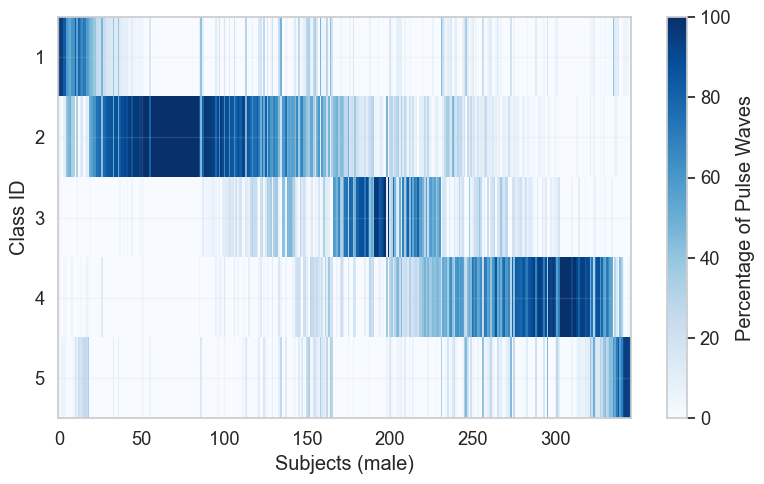

F
(340, 5)
Distribution of waves per class for F:
[ 3.3 43.3 30.9 20.3  2.2]


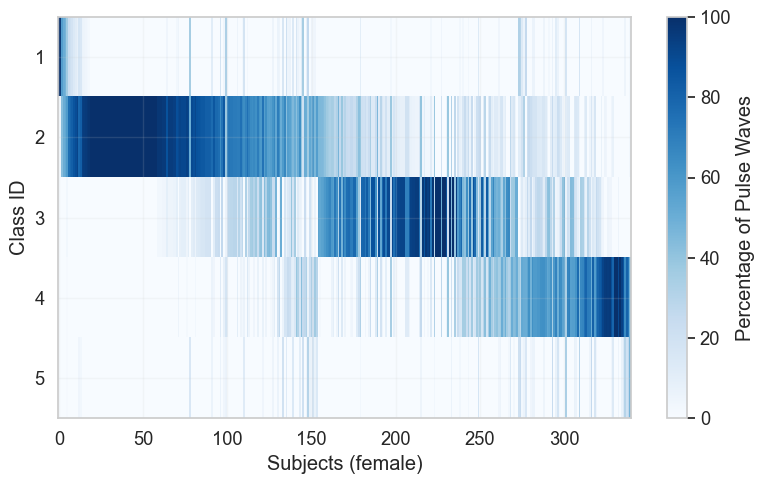

In [16]:
# count how many waves are of class 1,2,3,4,5 for each subject

print("Distribution of waves per class for each gender (M/F)")
for gender in set(available_genders): 
    print(gender) 
    
    wave_counts = []

    for i in data:
        if data[i]["gender"] == gender: 
            wave_arr = np.zeros(5)
            class_index, w_classes = np.unique(data[i]["individual_waves_classes"], return_counts=True)
            for class_id, w_class in zip(class_index, w_classes):
                wave_arr[class_id-1] = w_class 

            wave_counts.append(wave_arr)

    wave_counts = np.array(wave_counts)
    print(wave_counts.shape)  # (n_subjects, 5)

    # Get percentage of waves per class per person 
    wave_counts = wave_counts / np.sum(wave_counts, axis=1, keepdims=True)  # normalize each row to sum to 1

    # round to 2 decimal places
    wave_counts = np.round(wave_counts, 2)
    dist = np.sum(wave_counts, axis=0) / np.sum(wave_counts) 
    # print(np.mean(np.sum(wave_counts, axis=0), axis=0))  # total number of waves per subject.
    dist = np.round(dist*100, 1)
    print(f"Distribution of waves per class for {gender}:")
    print(dist)

    # plt.imshow(np.array(wave_counts).T, aspect='auto', cmap='viridis')
    # plt.show()


    # os.makedirs(os.path.join(OUTPUT_PATH, "class_analysises"), exist_ok=True)
    # ------------------------------------------------------------------
    # 1. L1-normalise each subject's counts  (sum of row = 1)
    # ------------------------------------------------------------------
    wave_norm  = wave_counts/np.mean(wave_counts, axis=1, keepdims=True) # normalize(wave_counts, norm='l1')   # shape (n_subj, 5)

    # ------------------------------------------------------------------
    # 2. Order subjects: first by MEDIAN class, then by MEAN class
    # ------------------------------------------------------------------
    class_ids = np.arange(1, 6)                       # [1, 2, 3, 4, 5]

    # --- weighted median ------------------------------------------------
    # cumulative sums along the class axis (row-wise)
    cum = np.cumsum(wave_counts, axis=1)
    # first index where cumulative ≥ 0.5  ➜ median class (add 1 for 1-based IDs)
    median_class = np.argmax(cum >= 0.5, axis=1) + 1  # shape (n_subjects,)

    # --- weighted mean --------------------------------------------------
    mean_class = (wave_counts * class_ids).sum(axis=1)   # shape (n_subjects,)

    # --- combined ordering ---------------------------------------------
    # np.lexsort uses the LAST key as the primary key, so we pass
    #   (secondary, primary)
    cluster_order = np.lexsort((mean_class, median_class))


    # ------------------------------------------------------------------
    # 3. Re-plot with the new column order
    # ------------------------------------------------------------------
    wave_classes = wave_norm / np.mean(wave_norm, keepdims=True) / 5
    wave_clust   = wave_classes[cluster_order]

    plt.figure(figsize=(8, 5))
    plt.imshow(wave_clust.T * 100, aspect='auto', cmap='Blues', interpolation='nearest')

    gender_label = {"F": "female", "M": "male"}
    plt.xlabel(f'Subjects ({gender_label[gender]})')
    plt.ylabel('Class ID')
    plt.colorbar(label="Percentage of Pulse Waves")
    # plt.title(f"Distribution of Classes of Waves, {gender}")
    plt.yticks(range(5), range(1, 6))
    plt.tight_layout()
    plt.show()


        



# Get stats for AURORA-BP dataset (mean ± std)

In [17]:
data["a000"].keys()

dict_keys(['age', 'gender', 'high_bp', 'baseline_sbp', 'baseline_dbp', 'height', 'weight', 'cvd_meds', 'fitzpatrick_scale', 'pressure_quality', 'optical_quality', 'raw_optical', 'delta_t', 'sampling_rate', 'ppg', 'vpg', 'apg', 'jpg', 'fiducials_pyPPG', 'individual_waves', 'fid_on_ppg', 'wave_durations', 'average_hr', 'rise_times_norm', 'rise_times_ms', 'average_rise_time_norm', 'average_rise_time_ms', 'ensemble_wave', 'individual_wave_derivs_ppg_arr', 'individual_wave_derivs_vpg_arr', 'individual_wave_derivs_apg_arr', 'individual_wave_derivs_jpg_arr', 'ensemble_ppg_avg', 'ensemble_vpg_avg', 'ensemble_apg_avg', 'ensemble_jpg_avg', 'oscillo_or_auscul', 'bmi', 'height_m', 'weight_kg', 'individual_waves_classes', 'ensemble_class', 'area_under_the_curve_unsign_wave', 'area_under_the_curve_sign_wave', 'area_under_the_curve_unsign', 'area_under_the_curve_sign'])

In [18]:
data["a000"]["average_rise_time_ms"]

np.float64(0.29980299996591686)

In [19]:
len(data["a000"]["raw_optical"]) / data["a000"]["sampling_rate"]

np.float64(21.025999997609656)

In [20]:
print("Number subjects: ", len(data))

# Get percentage female, get age (mean + std), height (mean + std), bmi (mean + std), sbp (mean + std), dbp (mean + std), recording duration (mean + sdt), and HR (mean + std)
number_of_female_subjects = sum(1 for d in data if data[d]["gender"] == "F")
print("Number of female subjects: ", number_of_female_subjects)
print("Percentage of female subjects: ", number_of_female_subjects / len(data) * 100)

mean_age = np.mean([data[d]["age"] for d in data])
std_age = np.std([data[d]["age"] for d in data])
print("Mean age: ", np.round(mean_age, 2), "±", np.round(std_age, 2))
mean_height = np.mean([data[d]["height_m"] for d in data])
std_height = np.std([data[d]["height_m"] for d in data])
print("Mean height: ", np.round(mean_height, 2), "±", np.round(std_height, 2))
mean_bmi = np.mean([data[d]["bmi"] for d in data])
std_bmi = np.std([data[d]["bmi"] for d in data])
print("Mean BMI: ", np.round(mean_bmi, 2), "±", np.round(std_bmi, 2))
mean_sbp = np.mean([data[d]["baseline_sbp"] for d in data])
std_sbp = np.std([data[d]["baseline_sbp"] for d in data])
print("Mean SBP: ", np.round(mean_sbp, 2), "±", np.round(std_sbp, 2))
mean_dbp = np.mean([data[d]["baseline_dbp"] for d in data])
std_dbp = np.std([data[d]["baseline_dbp"] for d in data])
print("Mean DBP: ", np.round(mean_dbp, 2), "±", np.round(std_dbp, 2))
all_raw_recording_durations = [len(data[d]["raw_optical"]) / data[d]["sampling_rate"] for d in data]
mean_recording_duration = np.mean(all_raw_recording_durations)
std_recording_duration = np.std(all_raw_recording_durations)
print("Mean recording duration: ", np.round(mean_recording_duration, 2), "±", np.round(std_recording_duration, 2))
mean_hr = np.mean([data[d]["average_hr"] for d in data])
std_hr = np.std([data[d]["average_hr"] for d in data])
print("Mean HR: ", np.round(mean_hr, 2), "±", np.round(std_hr, 2))
print("---")
mean_rise_time_ms = np.mean([data[d]["average_rise_time_ms"] for d in data])
std_rise_time_ms = np.std([data[d]["average_rise_time_ms"] for d in data])
print("Mean rise time (ms): ", np.round(mean_rise_time_ms, 2), "±", np.round(std_rise_time_ms, 2))

Number subjects:  686
Number of female subjects:  340
Percentage of female subjects:  49.56268221574344
Mean age:  43.98 ± 11.26
Mean height:  1.72 ± 0.1
Mean BMI:  28.54 ± 6.23
Mean SBP:  124.72 ± 16.72
Mean DBP:  76.14 ± 11.18
Mean recording duration:  24.64 ± 5.59
Mean HR:  65.83 ± 9.8
---
Mean rise time (ms):  0.34 ± 0.09


In [21]:
total_number_of_waves = 0
for d in data:
    total_number_of_waves += len(data[d]["individual_wave_derivs_ppg_arr"])
print("Total number of waves: ", total_number_of_waves)
print("Average number of waves per subject: ", np.round(total_number_of_waves / len(data), 2))

Total number of waves:  17873
Average number of waves per subject:  26.05


# Durations

21.025999997609656
30.0
All frequencies:  {np.float64(500.0), np.float64(500.00000005684257), np.float64(500.00000011368746)}
All frequencies:  {np.float64(500.00000001421074), np.float64(500.00000005684257), np.float64(500.0), np.float64(500.00000002842245)}


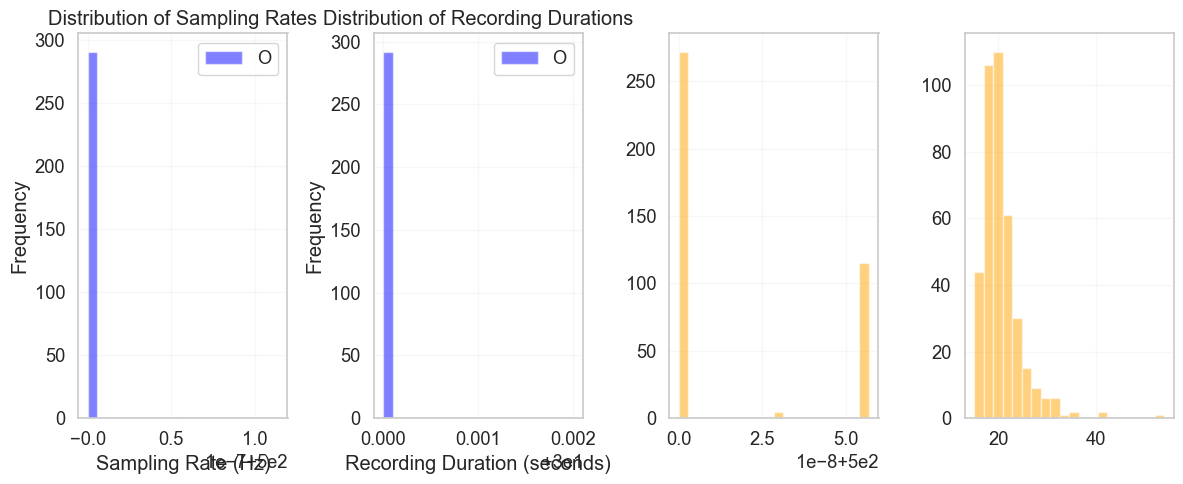

In [22]:
print(len(data["a000"]["raw_optical"])/ data["a000"]["sampling_rate"])  # duration of the recording in seconds
print(len(data["o000"]["raw_optical"])/ data["o000"]["sampling_rate"])  # duration of the recording in seconds

# Create two plots, each showing the distributions of sampling rate and recording duration for finger and wrist PPG data.
import matplotlib.pyplot as plt
import os
os.makedirs(os.path.join(OUTPUT_PATH, "finger_vs_wrist_sampling_rate_and_duration"), exist_ok=True)
# Create a figure with two subplots
fig, axes = plt.subplots(1, 4, figsize=(12, 5))
# Plot the distribution of sampling rates
axes[0].hist([data[d]["sampling_rate"] for d in data if data[d]["oscillo_or_auscul"][0] == "o"], bins=20, alpha=0.5, label='O', color='blue')
axes[2].hist([data[d]["sampling_rate"] for d in data if data[d]["oscillo_or_auscul"][0] == "a"], bins=20, alpha=0.5, label='A', color='orange')
axes[0].set_title('Distribution of Sampling Rates')
axes[0].set_xlabel('Sampling Rate (Hz)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
# Plot the distribution of recording durations
axes[1].hist([len(data[d]["raw_optical"])/data[d]["sampling_rate"] for d in data if data[d]["oscillo_or_auscul"][0] == "o"], bins=20, alpha=0.5, label='O', color='blue')
print("All frequencies: ", set(np.array([data[d]["sampling_rate"] for d in data if data[d]["oscillo_or_auscul"][0] == "o"])))
print("All frequencies: ", set(np.array([data[d]["sampling_rate"] for d in data if data[d]["oscillo_or_auscul"][0] == "a"])))
axes[3].hist([len(data[d]["raw_optical"])/data[d]["sampling_rate"] for d in data if data[d]["oscillo_or_auscul"][0] == "a"], bins=20, alpha=0.5, label='A', color='orange')
axes[1].set_title('Distribution of Recording Durations')
axes[1].set_xlabel('Recording Duration (seconds)')
axes[1].set_ylabel('Frequency')         
axes[1].legend()
# Adjust layout and save the figure
plt.tight_layout()

[np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.002), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(29.99999999658

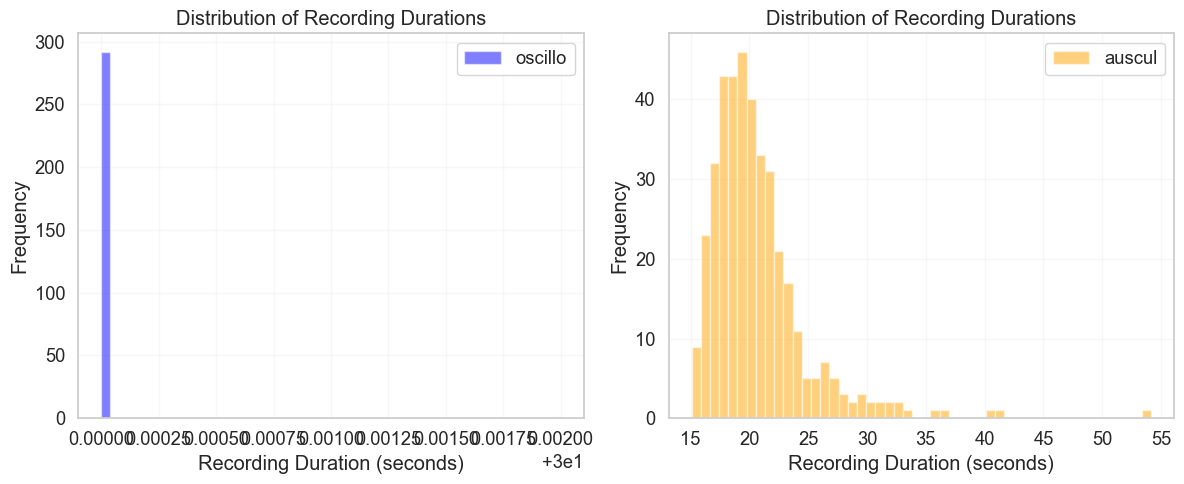

In [23]:
# print(len(data["a000"]["raw_optical"])/ data["a000"]["sampling_rate"])  # duration of the recording in seconds
# print(len(data["o000"]["raw_optical"])/ data["o000"]["sampling_rate"])  # duration of the recording in seconds

# Create two plots, each showing the distributions of sampling rate and recording duration for finger and wrist PPG data.
import matplotlib.pyplot as plt
import os
os.makedirs(os.path.join(OUTPUT_PATH, "finger_vs_wrist_sampling_rate_and_duration"), exist_ok=True)
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Plot the distribution of sampling rates
# axes[0].hist([data[d]["sampling_rate"] for d in data if data[d]["oscillo_or_auscul"][0] == "o"], bins=20, alpha=0.5, label='O', color='blue')
# axes[1].hist([data[d]["sampling_rate"] for d in data if data[d]["oscillo_or_auscul"][0] == "a"], bins=20, alpha=0.5, label='A', color='orange')
# axes[0].set_title('Distribution of Sampling Rates')
# axes[0].set_xlabel('Sampling Rate (Hz)')
# axes[0].set_ylabel('Frequency')
# axes[0].legend()
# Plot the distribution of recording durations
print([len(data[d]["raw_optical"])/data[d]["sampling_rate"] for d in data if data[d]["oscillo_or_auscul"][0] == "o"])
axes[0].hist([len(data[d]["raw_optical"])/data[d]["sampling_rate"] for d in data if data[d]["oscillo_or_auscul"][0] == "o"], bins=50, alpha=0.5, label='oscillo', color='blue')
axes[1].hist([len(data[d]["raw_optical"])/data[d]["sampling_rate"] for d in data if data[d]["oscillo_or_auscul"][0] == "a"], bins=50, alpha=0.5, label='auscul', color='orange')
axes[1].set_title('Distribution of Recording Durations')
axes[1].set_xlabel('Recording Duration (seconds)')
axes[1].set_ylabel('Frequency')         
axes[1].legend()

axes[0].set_title('Distribution of Recording Durations')
axes[0].set_xlabel('Recording Duration (seconds)')
axes[0].set_ylabel('Frequency')         
axes[0].legend()

# print number of subjects whose recording duration is less than 20 seconds. Print their ids
short_recordings = [d for d in data if len(data[d]["raw_optical"])/data[d]["sampling_rate"] < 15.5]
print(f"Number of subjects with recording duration less than 20 seconds: {len(short_recordings)}")
print(f"IDs of subjects with recording duration less than 20 seconds: {short_recordings}")  

# Adjust layout and save the figure
plt.tight_layout()

In [24]:
# print the seven shortest raw_optical recording lengths and their ids
shortest_recordings = sorted(data.items(), key=lambda x: len(x[1]["raw_optical"])/x[1]["sampling_rate"])[:7]
print("Seven shortest raw_optical recording lengths and their ids:")
for subj_id, subject_data in shortest_recordings:
    recording_length = len(subject_data["raw_optical"]) / subject_data["sampling_rate"]
    print(f"ID: {subj_id}, Recording Length: {recording_length:.2f} seconds")

Seven shortest raw_optical recording lengths and their ids:
ID: a067, Recording Length: 15.08 seconds
ID: a092, Recording Length: 15.17 seconds
ID: a321, Recording Length: 15.27 seconds
ID: a149, Recording Length: 15.35 seconds
ID: a547, Recording Length: 15.44 seconds
ID: a460, Recording Length: 15.49 seconds
ID: a381, Recording Length: 15.67 seconds
